In [1]:
'''
EloquentTinyML voice trainer v1.1 for Arduino Nano 33 BLE Sense
  by Alan Wang
Required packages:
  Tensorflow 2.x
  tinymlgen (https://github.com/eloquentarduino/tinymlgen)
  NumPy
  matplotlib
  scikit-learn
'''


import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # only print out fatal log

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

import tensorflow as tf
from tensorflow.keras import layers, Sequential


# force computer to use CPU if there are no GPUs present

tf.config.list_physical_devices('GPU')
tf.test.is_gpu_available()


# set random seed

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)


# import dataset and transform target (label data) to categorical arrays
import importlib.util
import sys
from google.colab import drive

drive.mount('/content/gdrive')

# To add a directory with your code into a list of directories 
# which will be searched for packages
sys.path.append('/content/gdrive/My Drive/ECE202A/model_training')

from appliance_dataset_new import data, target

# create training data (60%), validation data (20%) and testing data (20%)

data_train, data_test, target_train, target_test = train_test_split(
    data, target, test_size=0.2, random_state=RANDOM_SEED)
data_train, data_validate, target_train, target_validate = train_test_split(
    data_train, target_train, test_size=0.25, random_state=RANDOM_SEED)



# callbacks for the TF model (save best model and log)

checkpoint_file = 'voice_classifier'
log_file = 'voice_classifier_log'

tf_callback = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_file,
        save_weights_only=True,
        monitor='accuracy',
        mode='max',
        save_best_only=True),
    tf.keras.callbacks.TensorBoard(log_file)
]


# create a TF model

model = Sequential()
model.add(layers.Dense(data.shape[1], activation='relu', input_shape=(data.shape[1],)))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(np.unique(target).size * 4, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(np.unique(target).size, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


# training TF model

ITERATION = 3000
BATCH_SIZE = 4

history = model.fit(data_train, target_train,
                    epochs=ITERATION, batch_size=BATCH_SIZE,
                    validation_data=(data_validate, target_validate),
                    callbacks=tf_callback)

model.load_weights(checkpoint_file)  # load best model
predictions = model.predict(data_test)  # make predictions
test_score = model.evaluate(data_test, target_test)


# get the predicted label based on probability

predictions_categorical = np.argmax(predictions, axis=1)


# display prediction performance on validation data and test data

print('Prediction Accuracy:', accuracy_score(target_test, predictions_categorical).round(3))
print('Test accuracy:', round(test_score[1], 3))
print('Test loss:', round(test_score[0], 3))
print('')
print(classification_report(target_test, predictions_categorical))

Streaming output truncated to the last 5000 lines.
Epoch 509/3000
12/12 [==============================] - 0s 6ms/step - loss: 0.2971 - accuracy: 0.8958 - val_loss: 0.0729 - val_accuracy: 1.0000
Epoch 510/3000
12/12 [==============================] - 0s 5ms/step - loss: 0.1916 - accuracy: 0.9583 - val_loss: 0.0702 - val_accuracy: 1.0000
Epoch 511/3000
12/12 [==============================] - 0s 6ms/step - loss: 0.2283 - accuracy: 0.9375 - val_loss: 0.0620 - val_accuracy: 1.0000
Epoch 512/3000
12/12 [==============================] - 0s 5ms/step - loss: 0.2704 - accuracy: 0.9375 - val_loss: 0.0559 - val_accuracy: 1.0000
Epoch 513/3000
12/12 [==============================] - 0s 7ms/step - loss: 0.3213 - accuracy: 0.8958 - val_loss: 0.0503 - val_accuracy: 1.0000
Epoch 514/3000
12/12 [==============================] - 0s 7ms/step - loss: 0.1584 - accuracy: 0.9583 - val_loss: 0.0473 - val_accuracy: 1.0000
Epoch 515/3000
12/12 [==============================] - 0s 6ms/step - loss: 0.2980 - 

  Created wheel for tinymlgen: filename=tinymlgen-0.2-py3-none-any.whl size=2242 sha256=02a5ba6bb7f63d7dc7f1defb9ffadc507b496e9027e61609385236e5061f7fcc
  Stored in directory: /root/.cache/pip/wheels/1c/94/c7/a18049eea10532c9975ad7353fcccc7c436673285b4723a4bb
  Created wheel for hexdump: filename=hexdump-3.3-py3-none-any.whl size=8913 sha256=04aed3460b0013edd99edad1375c4c262c770f5a945a36289c8274f1233b6a6b
  Stored in directory: /root/.cache/pip/wheels/68/fe/aa/06fd9d6968cfc3e1926eeab1ec728c246dafa120a72ff9afae
Successfully built tinymlgen hexdump
INFO:tensorflow:Assets written to: /tmp/tmpoy_2xuup/assets


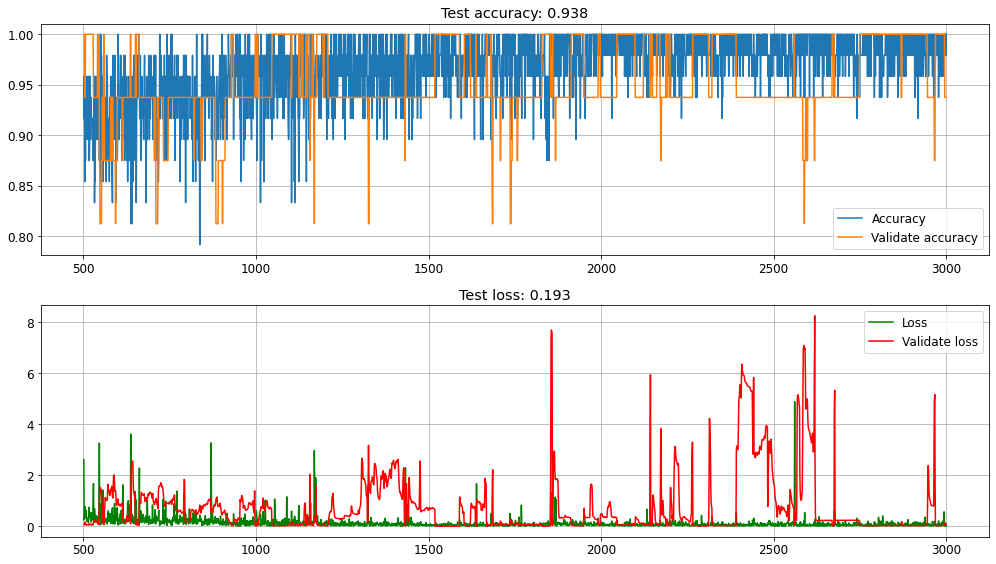

In [2]:
# convert TF model to TF Lite model as a C header file (for the classifier)

!pip install tinymlgen
from tinymlgen import port
with open('/content/gdrive/My Drive/ECE202A/model_training/tf_lite_model.h', 'w') as f:
    f.write(port(model, optimize=False))


# visualize prediction performance

DISPLAY_SKIP = 500

import matplotlib.pyplot as plt


accuracy = history.history['accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']
epochs = np.arange(len(accuracy)) + 1

plt.rcParams['font.size'] = 12
plt.figure(figsize=(14, 8))

plt.subplot(211)
plt.title(f'Test accuracy: {round(test_score[1], 3)}')
plt.plot(epochs[DISPLAY_SKIP:], accuracy[DISPLAY_SKIP:], label='Accuracy')
plt.plot(epochs[DISPLAY_SKIP:], val_accuracy[DISPLAY_SKIP:], label='Validate accuracy')
plt.grid(True)
plt.legend()

plt.subplot(212)
plt.title(f'Test loss: {round(test_score[0], 3)}')
plt.plot(epochs[DISPLAY_SKIP:], loss[DISPLAY_SKIP:], label='Loss', color='green')
plt.plot(epochs[DISPLAY_SKIP:], val_loss[DISPLAY_SKIP:], label='Validate loss', color='red')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()